# BM 336546 - HW2: Type 1 Diabetes (T1D)
Our goal is to predict if a patient suffers from T1D, by applying ML algorithms on the given dataset. 
# Part I: Data exploration


### 1) Loading the data

Let's start the assignment by loading the data and explain any preprocessing

Loading the data:

In [1]:
import pandas as pd 
import numpy as np
from pathlib import Path
import random
%reload_ext autoreload

file = Path.cwd().joinpath('HW2_data.csv') # concatenates HW2_data.csv to the current folder
T1D_dataset = pd.read_csv(file) # load the data

random.seed(10)  # fill your seed number here
print('hello')

hello


Now we can apply some preprocessing. We decided to fill the empty cells (nan) with random values from each column.

In [2]:
from helpers_function import nan2rand_val as rv

filled_dataset = rv(T1D_dataset)

### 2) Splitting the data


Now we will split our dataset into a train (80%) and test (20%) sets, using the sklearn function. We would like our sets to represent equally the classes (diagnosis yes or no) of the patients, therefore we will use the stratify method with the diagnosis column.

In [3]:
from sklearn.model_selection import train_test_split
X = filled_dataset.loc[:, 'Age':'Obesity']
X['Family History']=filled_dataset[['Family History']]
list_features = list(X.columns.values)
Y = T1D_dataset[['Diagnosis']]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,stratify=Y)

### 3) Visualizating the data

#### a. Repartition in test/train
First, let's plot a table showing the repartition of positive features (as the features have a binary result) in each set (train and test)

In [4]:
import matplotlib.pyplot as plt
fts = ['Muscle Stiffness', 'Hair Loss', 'Obesity', 'Partial Paresis', 'Delayed Healing']

partition_ft = pd.DataFrame(columns=['Positive Feature','% in train','% in test','difference'])

partition_ft['Positive Feature'] = fts
train_lst = []
test_lst = []
for ft in fts:
    pos_ft_train = np.sum(X_train[[ft]]=='Yes')
    train_lst.append(100*pos_ft_train/len(X_train[[ft]]))
    pos_ft_test = np.sum(X_test[[ft]]=='Yes')
    test_lst.append(100*pos_ft_test/len(X_test[[ft]]))
partition_ft[['% in train']] = train_lst
partition_ft[['% in test']] = test_lst
partition_ft[['difference']] = np.array(train_lst) - np.array(test_lst)
print(partition_ft)


   Positive Feature % in train % in test difference
0  Muscle Stiffness    37.6106   31.8584    5.75221
1         Hair Loss    36.7257   31.8584    4.86726
2           Obesity    17.0354   15.9292    1.10619
3   Partial Paresis    42.9204   41.5929    1.32743
4   Delayed Healing    46.2389   46.0177   0.221239


As we can notice, the difference between the percentage of positive features in the train and in the test set is lower than 10% (in absolute value). Hence, we can conclude that the data is distributed similarly in both sets (train and test).

An imbalance of features between train and test sets could cause a bad interpretation of the dataset; if in the train set, we have a lot more positive values ('Yes') for a specific feature, the model trained on it will be fitted accordingly (will be very accurate for that positive feature), but not taking in consideration the negative values ('No'), that we will surely interpret wrongly in the test set.

In order to solve such an issue, we can for example split the dataset using stratification (meaning taking in consideration the ratios for specific features).#more data

#### b. Relationship between features and label

We will now plot the relationship between features and label:

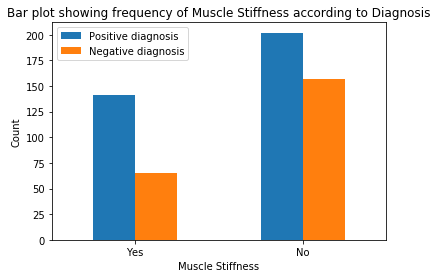

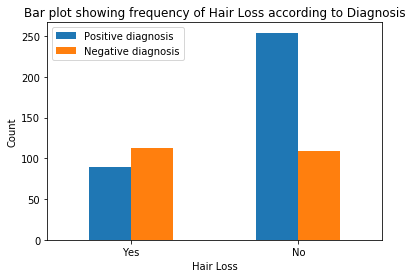

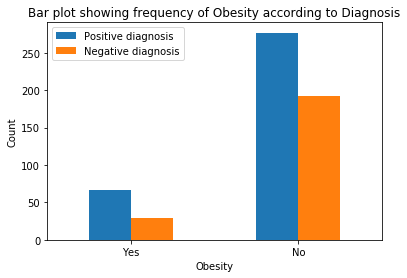

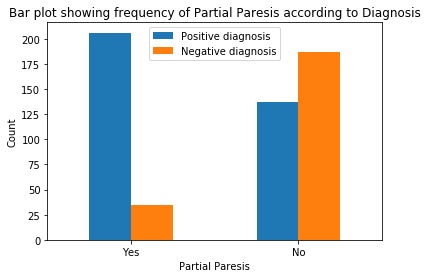

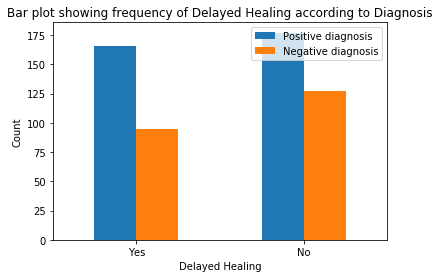

In [5]:
for ft in fts:
    DiagYesFt = filled_dataset[ft].loc[filled_dataset['Diagnosis'] == 'Positive']
    DiagYesFtYes = np.sum(DiagYesFt == 'Yes')
    DiagYesFtNo = np.sum(DiagYesFt == 'No')

    DiagNoFt = filled_dataset[ft].loc[filled_dataset['Diagnosis'] == 'Negative']
    DiagNoFtYes = np.sum(DiagNoFt == 'Yes')
    DiagNoFtNo = np.sum(DiagNoFt == 'No')
    DiagYes = [DiagYesFtYes, DiagYesFtNo]
    DiagNo = [DiagNoFtYes, DiagNoFtNo]
    index = ['Yes','No']
    df = pd.DataFrame({'Positive diagnosis': DiagYes,
                       'Negative diagnosis': DiagNo}, index=index)
    ax = df.plot.bar(rot=0)
    ax.set_xlabel(ft)
    ax.set_ylabel('Count')
    ax.set_title(f'Bar plot showing frequency of {ft} according to Diagnosis')
    

### 4) Encoding the data as one hot vectors 

We will now transform the dataset into one hot vectors:

In [6]:
from helpers_function import to_one_hot as one_hot
'''
bin_Xtrain = one_hot(X_train)
bin_Xtest = one_hot(X_test)
bin_ytrain = one_hot(y_train)
bin_ytest = one_hot(y_test)
'''
bin_Xtrain = pd.get_dummies(X_train)
bin_Xtest = pd.get_dummies(X_test)
bin_ytrain = pd.get_dummies(y_train)
bin_ytest = pd.get_dummies(y_test)

### 5) 5K Cross Fold Validation and evaluation of two models

Let's start by doing a 5K cross fold validation. 

In this section, we want to train one linear model (we chose logistic regression) and one non-linear model (we chose random forest), tuning their ideal parameters with a 5K cross fold validation and reporting their ROC AUC result.

We start by tuning the logistic regression model:

In [7]:
from sklearn.model_selection import StratifiedKFold as SKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, f1_score

import warnings
from helpers_function import tune_LogReg, tune_RandForest

kf = SKFold(n_splits=5)
best_params = tune_LogReg(kf, bin_Xtrain, bin_ytrain)
print(best_params)

{'C': 1.0, 'penalty': 'elasticnet', 'auc_score': 0.9722222222222222}


Let's report the performance score on the test set using the tuned parameters:

In [8]:
from sklearn.metrics import accuracy_score
from helpers_function import report_performance

clf = LogisticRegression(solver='saga',penalty=best_params['penalty'], C=best_params['C'], 
                   max_iter=100000, class_weight='balanced', l1_ratio=0.5).fit(bin_Xtrain,bin_ytrain.iloc[:,1])

indexes = ['Logistic Regression, on train','Logistic Regression, on test',
           'Random Forest, on train', 'Random Forest, on test']
df_scores = pd.DataFrame(columns=['F1 score','Accuracy','ROC AUC','Log loss'], index=indexes)
df_scores.loc['Logistic Regression, on train'] = report_performance(clf,bin_Xtrain, bin_ytrain.iloc[:,1])
df_scores.loc['Logistic Regression, on test'] = report_performance(clf,bin_Xtest, bin_ytest.iloc[:,1])


print(df_scores.head(2))

                               F1 score  Accuracy   ROC AUC Log loss
Logistic Regression, on train  0.934334  0.922566  0.977569   2.0956
Logistic Regression, on test   0.899225  0.884956  0.979249  3.40246


Let's see if we can do better with a non-linear model.

Let's tune the Random forest model:

In [9]:
from sklearn.ensemble import RandomForestClassifier
best_params = tune_RandForest(kf, bin_Xtrain, bin_ytrain)

print(best_params)

{'Nb_trees': 200, 'Criterion': 'gini', 'Max_features': 2, 'oob_score': False, 'auc_score': 0.9994949494949494}


Let's report the performance score on the test set using the tuned parameters:

In [10]:
clf = RandomForestClassifier(class_weight='balanced', n_estimators=best_params['Nb_trees'],
                             criterion=best_params['Criterion'], max_features=best_params['Max_features'], 
                             oob_score=best_params['oob_score']).fit(bin_Xtrain,bin_ytrain.iloc[:,1])
y_pred = clf.predict(bin_Xtest)
f1_sc = f1_score(bin_ytest.iloc[:,1], y_pred)
acc_sc = accuracy_score(bin_ytest.iloc[:,1], y_pred)
y_pred_prob = clf.predict_proba(bin_Xtest)[:,1]
auc_sc = roc_auc_score(bin_ytest.iloc[:,1], y_pred_prob)
log_loss_sc = log_loss(bin_ytest.iloc[:,1], y_pred_prob)

df_scores.loc['Random Forest, on train'] = report_performance(clf,bin_Xtrain, bin_ytrain.iloc[:,1], type_decision='predict_proba')
df_scores.loc['Random Forest, on test'] = report_performance(clf,bin_Xtest, bin_ytest.iloc[:,1], type_decision='predict_proba')
print(df_scores.head(4))

                               F1 score  Accuracy   ROC AUC   Log loss
Logistic Regression, on train  0.934334  0.922566  0.977569     2.0956
Logistic Regression, on test   0.899225  0.884956  0.979249    3.40246
Random Forest, on train               1         1         1  0.0294214
Random Forest, on test                1         1         1  0.0779698


As we can notice, a non-linear model seems to fit better to our problem. All the performance scores are better for Random forest.

### 6) Feature importance

Now, we would like to use our random forest model in order to find the two most important features of our dataset:

['Increased Thirst_Yes', 'Increased Urination_Yes']
[0.0912790797447168, 0.11075744623633664]


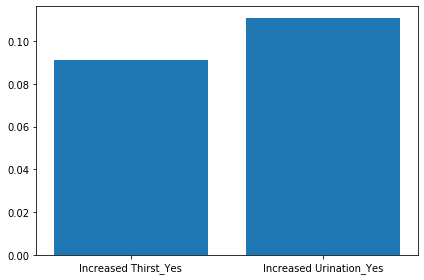

In [43]:
from  matplotlib import pyplot as plt
importance = clf.feature_importances_

# summarize feature importance

df_pvals_labels = list(bin_Xtrain.columns.values)

sorted_labels = [x for _,x in sorted(zip(importance,df_pvals_labels))]

sorted_imp = sorted(importance)

sorted_labels = sorted_labels[30:]
sorted_imp = sorted_imp[30:]
print(sorted_labels)
print(sorted_imp)
fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar([x for x in range(len(importance[30:]))], sorted_imp,
                     align='center', tick_label=sorted_labels)
#ax.set_xticklabels(sorted_labels, rotation=45 )
#plt.xticks(rotation=45)
plt.tight_layout()

plt.show()



That's all folks!